In [13]:
import EITfunc.EITlook as eit
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import itertools
import copy

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.ndimage import median_filter, gaussian_filter

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#columns:
# t_obs[JD] firstOrderFlux[normalized] firstOrderFluxUnc[normalized] centralOrderFlux[normalized] centralOrderFluxUnc[normalized]
#days without observations have flux=nan, fluxerr=nan
sem = np.genfromtxt("./SEM_LC_norm.txt")
#print(sem)
print(np.shape(sem))

#start time at 0
sem[:,0] = sem[:,0] - sem[0,0]

(10277, 5)


In [15]:
noObs = np.isnan(sem[:,1])
n_noObs = len(sem[:,0][noObs])
print(n_noObs)
dutyCycle = n_noObs/len(sem)
print(dutyCycle)

267
0.025980344458499564


In [16]:
#linearly interpolate missing data points (for now)
def linearlyInterpolateGaps(t, f, ferr):
    f = copy.deepcopy(f)
    ferr = copy.deepcopy(ferr)
    noObs = np.isnan(f)
    noObsIdxs = np.arange(len(t))[noObs]
    obsIdxs = np.arange(len(t))[~noObs]
    for i in noObsIdxs:
        prevGood = obsIdxs[obsIdxs <= i][-1]
        nextGood = obsIdxs[obsIdxs > i][0]
        #print(prevGood, i, nextGood)
        f[i] = f[prevGood] + ((t[i] - t[prevGood])/(t[nextGood]-t[prevGood]))*(f[nextGood] - f[prevGood])
        ferr[i] = np.abs(f[prevGood] - f[nextGood]) + 2*np.max((ferr[prevGood],ferr[nextGood]))
    return f, ferr

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    

In [32]:
f1, f1err = linearlyInterpolateGaps(sem[:,0], sem[:,1], sem[:,2])
f0, f0err = linearlyInterpolateGaps(sem[:,0], sem[:,3], sem[:,4])

f1_smoothed_101 = median_filter(f1,size=101,mode='nearest')
f1_smoothed_1001 = median_filter(f1,size=1001,mode='nearest')

f0_smoothed_101 = median_filter(f0,size=101,mode='nearest')
f0_smoothed_1001 = median_filter(f0,size=1001,mode='nearest')

medium_smoothing_sigma = 21
extreme_smoothing_sigma = 365.25/2

f1_gsmoothed_101 = gaussian_filter(f1,sigma=medium_smoothing_sigma,mode='nearest')
f1_gsmoothed_1001 = gaussian_filter(f1,sigma=extreme_smoothing_sigma,mode='nearest')

f0_gsmoothed_101 = gaussian_filter(f0,sigma=medium_smoothing_sigma,mode='nearest')
f0_gsmoothed_1001 = gaussian_filter(f0,sigma=extreme_smoothing_sigma,mode='nearest')


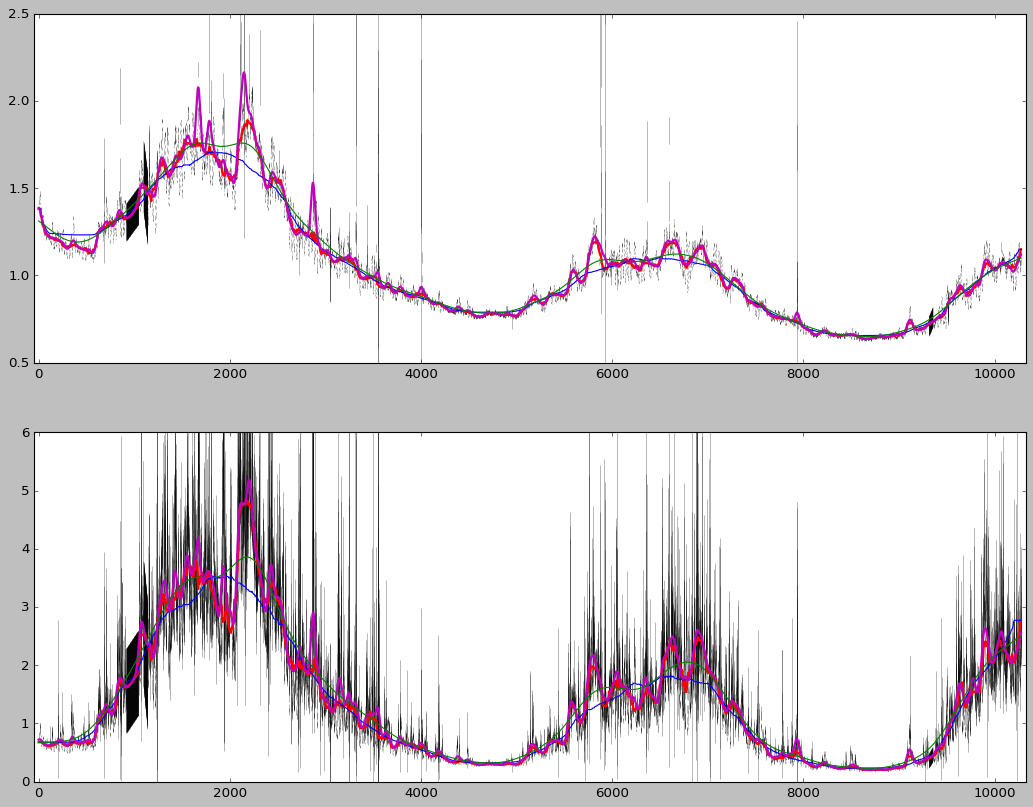

In [38]:
fig, axes = plt.subplots(2,1,figsize=(16,12))
axes[0].errorbar(sem[:,0], f1, yerr=f1err, marker='None',color='k',ls='None',capsize=0, elinewidth=0.5,alpha=0.5)
axes[0].plot(sem[:,0],f1_smoothed_101,'r-',lw=2)
axes[0].plot(sem[:,0],f1_smoothed_1001,'b-',lw=1)
axes[0].plot(sem[:,0],f1_gsmoothed_101,'m-',lw=2)
axes[0].plot(sem[:,0],f1_gsmoothed_1001,'g-',lw=1)
axes[0].set_ylim(0.5,2.5)

axes[1].errorbar(sem[:,0], f0, yerr=f0err, marker='None',color='k',ls='None',capsize=0, elinewidth=0.5,alpha=0.5)
axes[1].plot(sem[:,0],f0_smoothed_101,'r-',lw=2)
axes[1].plot(sem[:,0],f0_smoothed_1001,'b-',lw=1)
axes[1].plot(sem[:,0],f0_gsmoothed_101,'m-',lw=2)
axes[1].plot(sem[:,0],f0_gsmoothed_1001,'g-',lw=1)
axes[1].set_ylim(0,6)

for ax in axes:
    ax.set_xlim(sem[0,0]-50, sem[-1,0]+50)
plt.show()

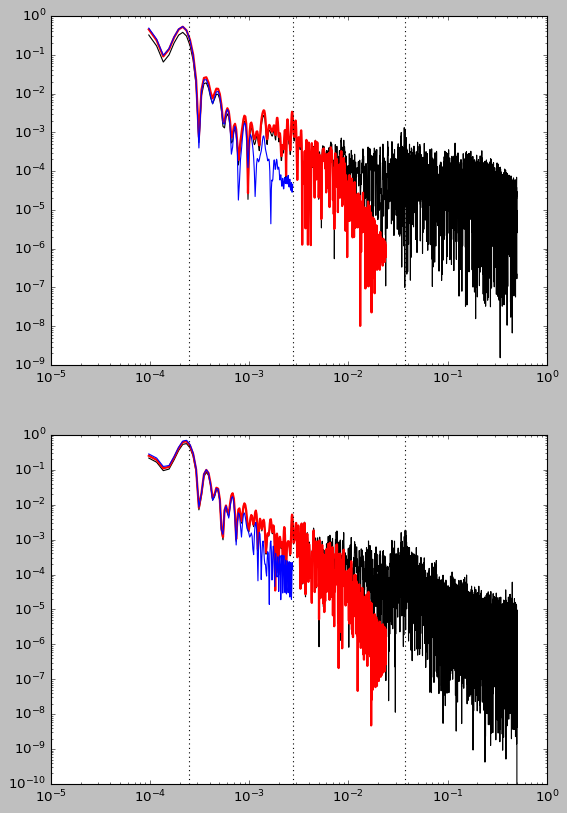

4670.909090909091
4281.666666666667


In [39]:
freq1, pow1 = LombScargle(sem[:,0],f1).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./2.))
freq1_smooth, pow1_smooth= LombScargle(sem[:,0],f1_gsmoothed_101).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./(2.*medium_smoothing_sigma)))
freq1_smooth2, pow1_smooth2= LombScargle(sem[:,0],f1_gsmoothed_1001).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./(2.*extreme_smoothing_sigma)))

freq0, pow0 = LombScargle(sem[:,0],f0).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./2.))
freq0_smooth, pow0_smooth= LombScargle(sem[:,0],f0_gsmoothed_101).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./(2.*medium_smoothing_sigma)))
freq0_smooth2, pow0_smooth2= LombScargle(sem[:,0],f0_gsmoothed_1001).autopower(minimum_frequency=(1./np.ptp(sem[:,0])), maximum_frequency=(1./(2.*extreme_smoothing_sigma)))

fig,axes = plt.subplots(2,1,figsize=(8,12))
axes[0].plot(freq1,pow1,'k-')
axes[0].plot(freq1_smooth,pow1_smooth,'r-',lw=2)
axes[0].plot(freq1_smooth2,pow1_smooth2,'b-',lw=1)

axes[1].plot(freq0,pow0,'k-')
axes[1].plot(freq0_smooth,pow0_smooth,'r-',lw=2)
axes[1].plot(freq0_smooth2,pow0_smooth2,'b-',lw=1)

for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.axvline(1/(11*365.),color='k',ls=':')
    ax.axvline(1/365.,color='k',ls=':')
    ax.axvline(1/27.,color='k',ls=':')
plt.show()

qp_time = 1./freq1[np.argmax(pow1)]
print(qp_time)

qp_time = 1./freq0[np.argmax(pow0)]
print(qp_time)

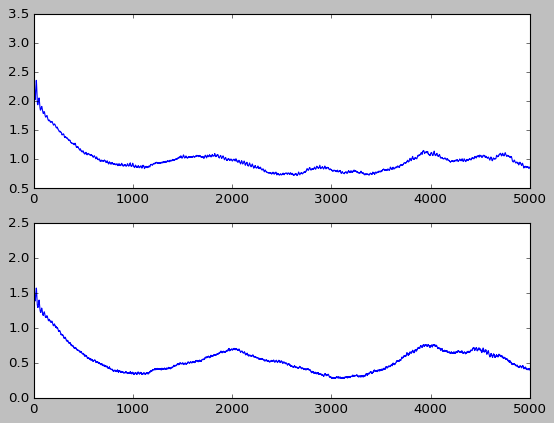

In [22]:
trialDelayIndices = np.arange(1,5001,1)
MI1 = np.zeros_like(trialDelayIndices,dtype='float')
MI0 = np.zeros_like(trialDelayIndices,dtype='float')
for i,tau in enumerate(trialDelayIndices):
    MI1[i] = sp.calc_MI(f1[:-(tau+1)], f1[(tau+1):],Xbins=sp.optimal_Nbins(f1[:-(tau+1)]), Ybins = sp.optimal_Nbins(f1[(tau+1):]))
    MI0[i] = sp.calc_MI(f0[:-(tau+1)], f0[(tau+1):],Xbins=sp.optimal_Nbins(f0[:-(tau+1)]), Ybins = sp.optimal_Nbins(f0[(tau+1):]))

fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].plot(trialDelayIndices,MI1,'b-')
axes[1].plot(trialDelayIndices,MI0,'b-')
plt.show()

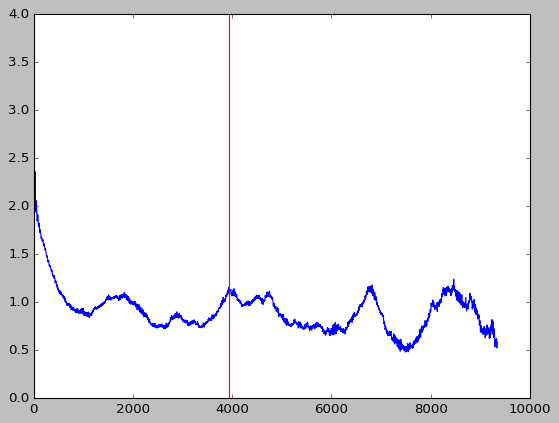

3928


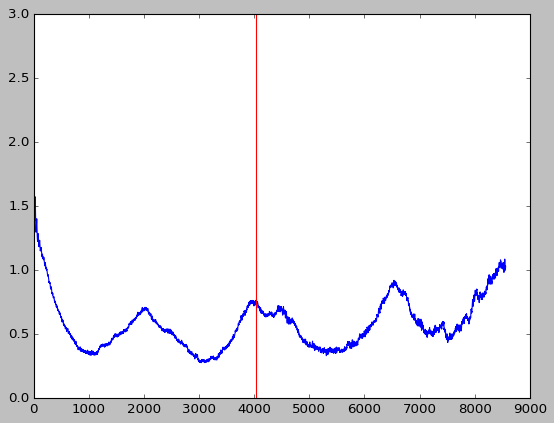

4025


In [23]:
qp_idx1, MI1 = sp.estimateQuasiPeriod(time=sem[:,0], timeSeries=f1, method="power", plot=True, return_MI=True)
print(qp_idx1)
qp_idx0, MI0 = sp.estimateQuasiPeriod(time=sem[:,0], timeSeries=f0, method="power", plot=True, return_MI=True)
print(qp_idx0)

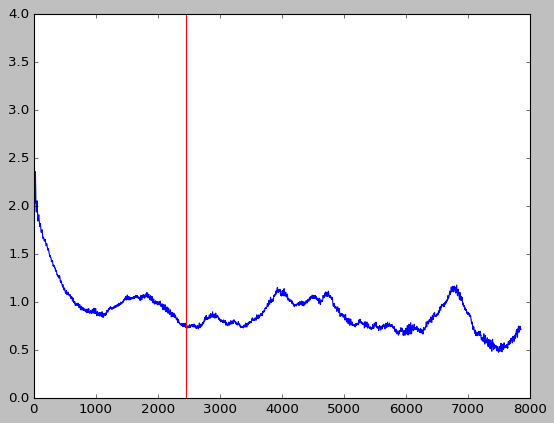

3928
2451


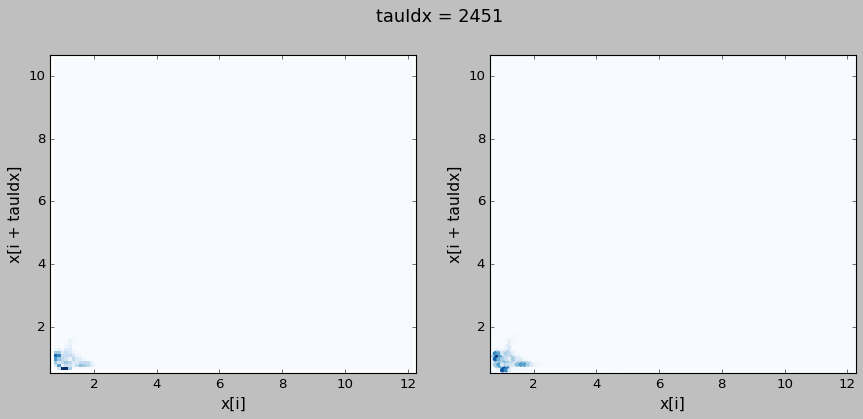

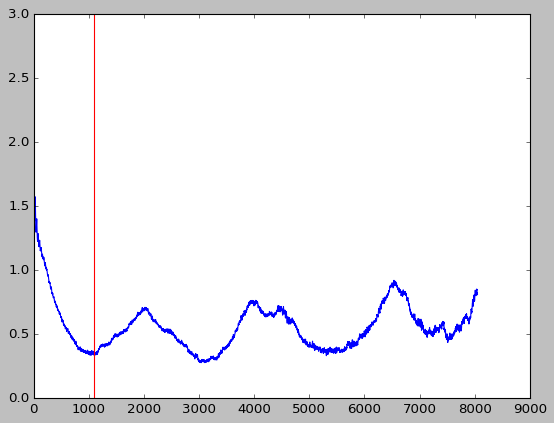

4025
1094


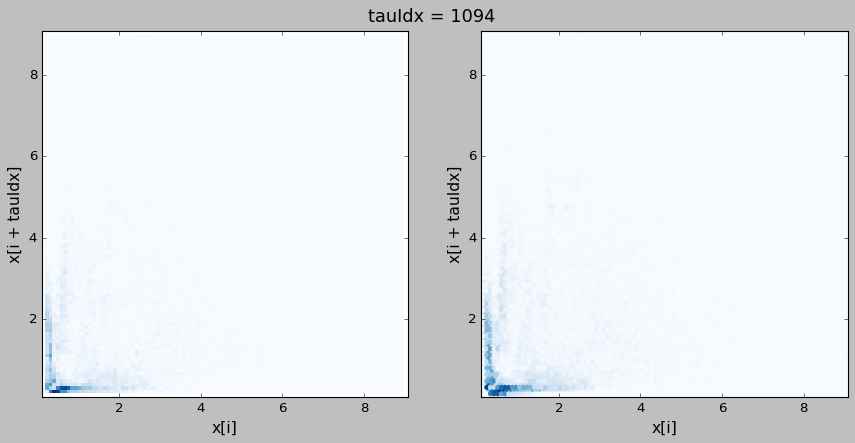

In [24]:
mutInfo1, bestTauIdx1, qp1 = sp.FS86(time = sem[:,0], timeSeries = f1, QPmethod="power", method="first_or_second_local_min", plot=True)
print(qp1)
print(bestTauIdx1)
mutInfo0, bestTauIdx0, qp0 = sp.FS86(time = sem[:,0], timeSeries = f0, QPmethod="power", method="first_or_second_local_min", plot=True)
print(qp0)
print(bestTauIdx0)                         

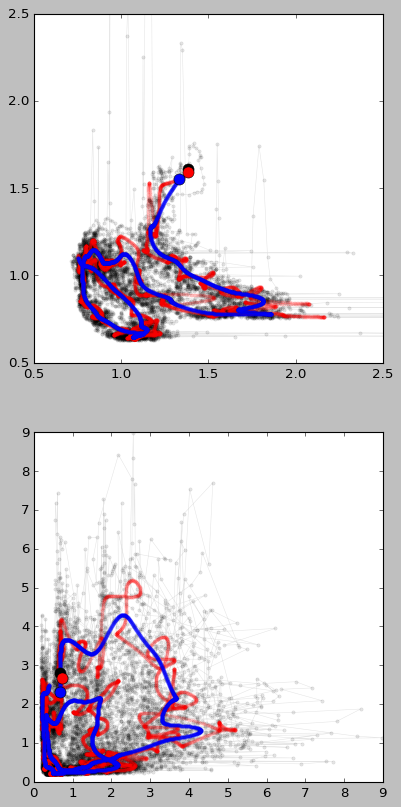

In [25]:
fig, axes = plt.subplots(2,1,figsize=(8,12))

axes[0].plot(f1[:-bestTauIdx1],f1[bestTauIdx1:],'k.',ls='-',lw=0.5,alpha=0.1)
axes[0].plot(f1_gsmoothed_101[:-bestTauIdx1],f1_gsmoothed_101[bestTauIdx1:],'r.',ls='-',lw=0.5,alpha=0.1)
axes[0].plot(f1_gsmoothed_1001[:-bestTauIdx1],f1_gsmoothed_1001[bestTauIdx1:],'b.',ls='-',lw=0.5,alpha=0.1)

axes[0].plot(f1[0],f1[bestTauIdx1],'ko',ms=10)
axes[0].plot(f1_gsmoothed_101[0],f1_gsmoothed_101[bestTauIdx1],'ro',ms=10)
axes[0].plot(f1_gsmoothed_1001[0],f1_gsmoothed_1001[bestTauIdx1],'bo',ms=10)

axes[0].set_xlim(0.5,2.5)
axes[0].set_ylim(0.5,2.5)

axes[1].plot(f0[:-bestTauIdx0],f0[bestTauIdx0:],'k.',ls='-',lw=0.5,alpha=0.1)
axes[1].plot(f0_gsmoothed_101[:-bestTauIdx0],f0_gsmoothed_101[bestTauIdx0:],'r.',ls='-',lw=0.5,alpha=0.1)
axes[1].plot(f0_gsmoothed_1001[:-bestTauIdx0],f0_gsmoothed_1001[bestTauIdx0:],'b.',ls='-',lw=0.5,alpha=0.1)

axes[1].plot(f0[0],f0[bestTauIdx0],'ko',ms=10)
axes[1].plot(f0_gsmoothed_101[0],f0_gsmoothed_101[bestTauIdx0],'ro',ms=10)
axes[1].plot(f0_gsmoothed_1001[0],f0_gsmoothed_1001[bestTauIdx0],'bo',ms=10)

for ax in axes:
    ax.set_aspect('equal')
plt.show()